In [1]:
!pip install numpy
!pip install matplotlib
!pip install scikit-image
!pip install pillow
!pip install opencv-python
!pip install timm
!pip install tqdm
# Check is at least python 3.9
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from PIL import Image
from typing import Callable
import os
from datetime import datetime
from enum import Enum
import random
from skimage.color import rgb2gray, rgb2hsv
from skimage import filters
from skimage import segmentation
from skimage.morphology import remove_small_holes, remove_small_objects
import cv2 as cv

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import timm
import torchvision
from torchvision.models.vision_transformer import vit_b_16
from torchvision.models import ViT_B_16_Weights

c:\Users\iab_b\miniconda3\envs\iapr_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import platform

# Get os name
os_name = platform.system().lower()
num_workers = 8

# OS X
if 'darwin' in os_name:
    print("Detected OS X")
    %pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.1
# Linux 
elif 'linux' in os_name:
    print("Detected Linux")
    %pip install torch==1.8.1 torchvision==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
# Windows 
else:
    print("Detected Windows")
    num_workers = 0  # Hard fix for Windows users
    %pip install torch==1.12.0 torchvision==0.13 -f https://download.pytorch.org/whl/torch_stable.html


Detected Windows


Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pillow!=8.3.*,>=5.3.0 in c:\users\iab_b\miniconda3\envs\iapr_project\lib\site-packages (from torchvision==0.13) (10.3.0)



In [5]:
class ImageType(Enum):
    NEUTRAL = "1. neutral_bg"
    NOISY = "2. noisy_bg"
    HAND = "3. hand"
    NEUTRAL_OOD = "4. neutral_bg_outliers"
    NOISY_OOD = "5. noisy_bg_outliers"
    HAND_OOD = "6. hand_outliers"
    
def loadImageOfType(type: ImageType, downsample: int = 1, grayscale: bool = False):
    # directory = f"./data/train/{type}"
    directory = os.path.join(".", "data", "train", type.value)
    images = os.listdir(directory)
    img = np.array(Image.open(os.path.join(directory, random.choice(images)))) 
    if downsample > 1:
        img = img[::downsample, ::downsample, :]
    if grayscale:
        img = (rgb2gray(img)*255).astype(np.uint8)
        
    # img = filters.sobel(img)
    
    return img
        


## Preprocessing

In [6]:
def filter_circles(circle_array):
    # print(circle_array)
    # Convert the array to a NumPy array
    
    # Find unique center coordinates
    unique_centers, unique_indices = np.unique(circle_array[:, :2], axis=0, return_index=True)
    # print(unique_indices)
    
    # Get the indices of circles with largest radius for each unique center
    largest_circles = []
    for center in unique_centers:
      largest_circle = np.array((center[0], center[1], 0))
      for j in range(len(circle_array)):
        circle = circle_array[j]
        if (circle[0] == center[0] and circle[1]==center[1] and circle[2] > largest_circle[2]):
          largest_circle[2] = circle[2] 
      largest_circles.append(largest_circle)
  
    # print(largest_circles)
               
      

    # # Convert the list of indices to a NumPy array
    # max_radius_indices = np.array(max_radius_indices)
    # print(max_radius_indices)
    
    return np.array(largest_circles)

In [7]:
# the input is a cv image so x and y are swapped
def extract_circles_images(x, y, r, img, down):
    factor = r + 10
    left = (x - factor)*down
    right = (x + factor)*down
    up = (y - factor)*down
    bottom = (y + factor)*down
    output = img.copy()
    output[:, :, 0] = img[:, :, 2]
    output[:, :, 2] = img[:, :, 0]
    return output[up:bottom, left:right, :]

In [8]:
def find_circles(path, debug = False):
    img = cv.imread(path)
    full_size_img = img.copy()
    down = 3
    size = (int(img.shape[1]/down), int(img.shape[0]/down))
    img = cv.resize(img, size, interpolation=cv.INTER_LINEAR)

    output = img.copy()
    output[:, :, 0] = img[:, :, 2]
    output[:, :, 2] = img[:, :, 0]
    img[:, :, 2] = 0

    gray = cv.blur(cv.cvtColor(img, cv.COLOR_BGR2GRAY), (8, 8))

    # detect circles in the image
    circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT_ALT, dp=1, minDist = 50, minRadius=50, maxRadius=200, param1=5, param2=0.6)
    # ensure at least some circles were found
    circles_imgs = []
    if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")
        circles = filter_circles(circles)
        print(f"detected {len(circles)} circles")
    
        for (x, y, r) in circles:
            # print(x, y, r)
            # draw the circle in the output image, then draw a rectangle
                # corresponding to the center of the circle
            cv.circle(output, (x, y), r, (0, 255, 0), 4)
            cv.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 255, 0), -1)
            new_circle = extract_circles_images(x, y, r, full_size_img, down)
            circles_imgs.append(new_circle)
            if debug:
                plt.imshow(new_circle)
                plt.show()
            # circles_imgs.append(extract_circles_images(x, y, r, output))
    
        # show the output image
    if debug:
        plt.imshow(output)
        plt.show()
    return circles_imgs

In [9]:
def get_training_data_paths():
    training_paths = []
    base_dir = "./data/train/"
    for d in os.listdir(base_dir):
        training_dir = f"{base_dir}/{d}"
        for path in os.listdir(training_dir):
            file_path = f"{training_dir}/{path}"
            training_paths.append(file_path)
            # print(file_path)
    return training_paths
        
# get_training_data_paths()

In [10]:
def get_label_for_image(path):
    filename = path.split("/")[-1].split(".")[0]

    data = np.genfromtxt('./data/train_labels.csv', delimiter=',', dtype=str)

# Assume the first column contains the strings you want to search through
    first_column = data[:, 0]

    # Find the index of the first entry that matches your string
    index = np.where(first_column == filename)[0]
    
    if index.size > 0:
        # print(f"The first entry matching '{filename}' is at index {index[0]}.")
        #we add 0 in order to account for non coins
        label_vector = np.append(data[index[0]][1:], 0)
        # print(label_vector)
        return torch.from_numpy(label_vector.astype(np.float32))
        # You can access the corresponding row using data[index[0]]
    else:
        # print(f"No entry matching '{filename}' found.")
        return torch.zeros(0)


detected 5 circles


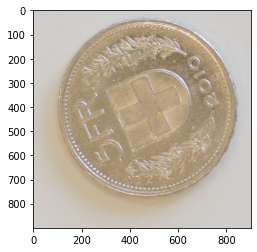

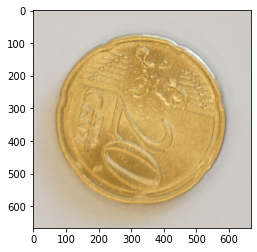

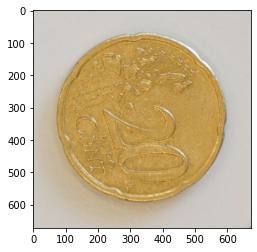

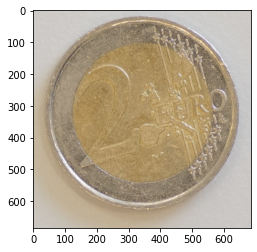

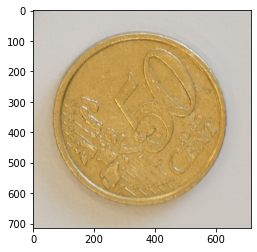

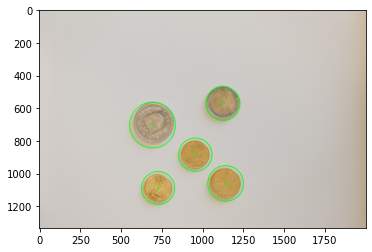

In [11]:
# d = "./data/train/1. neutral_bg//"
# d = "./data/train/2. noisy_bg///"
# d = "./data/train/3. hand///"
d = "./data/train/5. noisy_bg_outliers/"
# d = "./data/train/6. hand_outliers///"
# d = "./data/test//"
# for f in os.listdir(d):

paths = get_training_data_paths()
p = paths[0]
if get_label_for_image(p).shape[0] == 0:
    print("wrong filename")

circles = find_circles(paths[0], debug=True)
# for path in get_training_data_paths():
# img = cv.imread(f"{d}/{f}")[::3, ::3].astype(np.uint8)
# img[:, :, 1] = 0



In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [13]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
resnet152 = torchvision.models.resnet152(weights=torchvision.models.ResNet152_Weights.IMAGENET1K_V2).to(device)
def extract_features(input_image):
    # or any of these variants
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
    resnet152.eval()
    feature_extractor = torch.nn.Sequential(*list(resnet152.children())[:-1])

    image_dim = torch.tensor([input_image.shape[0]]).to(device)
    # print(image_dim)

    input_image = Image.fromarray(input_image)
    # input_image.show()
    preprocess = transforms.Compose([
        # transforms.Resize(256),
        transforms.CenterCrop(850),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    
    # plt.imshow(input_tensor.permute(1, 2, 0))
    # plt.show()
    
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available

    input_batch = input_batch.to(device)
    feature_extractor.to(device)

    with torch.no_grad():
        features = feature_extractor(input_batch)
    # Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
    # print(output[0])
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    # probabilities = torch.nn.functional.softmax(output[0], dim=0)
    features = torch.flatten(features)
    # features = torch.cat((features, image_dim))

    # print(features.size())
    return features




In [14]:
# # Step 1: Load a pre-trained ViT model
# vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1).to(device)
# # model = timm.create_model('vit_base_patch16_224', pretrained=True,  ViT_B_16_Weights.IMAGENET1K_V1:)

# # Step 2: Modify the model to be a feature extractor
# # Remove the classification head
# vit.head = nn.Identity()
# def extract_features_vit(input_image):

#     # Set the model to evaluation mode
#     vit.eval()

#     # Step 3: Define the transformation pipeline
#     transform = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#         # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#     ])

#     # Step 4: Load an image and preprocess it
#     # image_path = get_training_data_paths()[0]
#     # image_path = 'path_to_your_image.jpg'  # Replace with your image path
#     image = Image.fromarray(input_image)
    
#     # image = Image.open(image_path)
#     image = transform(image).to(device)
#     # display_image = (image.permute(1, 2, 0)*255).int()
#     # print(display_image)
#     # plt.imshow(display_image)
#     # plt.show()
    
#     image = image.unsqueeze(0)  # Add batch dimension
#     feats = vit._process_input(image)
#     # Step 5: Extract features
#     with torch.no_grad():
#         # features = vit(image)
#         batch_class_token = vit.class_token.expand(image.shape[0], -1, -1)
#         feats = torch.cat([batch_class_token, feats], dim=1)

#         feats = vit.encoder(feats)

#         # We're only interested in the representation of the CLS token that we appended at position 0
#         feats = feats[:, 0]

#         # print(feats.shape)
#         return feats


In [15]:
for circle in circles:
    print(extract_features(circle).shape)

torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048])


In [16]:
def get_test_data_paths():
    test_paths = []
    base_dir = "./data/test/"
    for path in os.listdir(base_dir):
        file_path = f"{base_dir}/{path}"
        test_paths.append(file_path)
            # print(file_path)
    return test_paths



## Training on individual coin

In [17]:
linear = torch.nn.Sequential( 
    torch.nn.Linear(in_features = 2048, out_features = 512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features = 512, out_features = 17), 
    # torch.nn.ReLU(),
    # torch.nn.Linear(in_features = 256, out_features = 17), 
    # torch.nn.Softmax(dim=1) 
)

linear = linear.to(device)


In [18]:
class_names = ["chf_5", "chf_2", "chf_1", "chf_0.5", "chf_0.2", "chf_0.1", "chf_0.05", "eur_2", "eur_1", "eur_0.5", "eur_0.2", "eur_0.1", "eur_0.05", "eur_0.02", "eur_0.01", "OOD", "bg"]


In [19]:
def get_training_set_size():
    size = 0
    for index, c in enumerate(class_names):
        labeled_coins_dir = "./data/labeled_coins/"
        selected_dir = f"{labeled_coins_dir}{c}"
        files = os.listdir(selected_dir)
        size += len(files)
    return size

print(get_training_set_size())

411


In [20]:
import random
from PIL import Image as im 

criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(linear.parameters(), lr=5e-4)

data_set_size = get_training_set_size()

trainX = torch.zeros((data_set_size, 2048)).to(device)
trainY = torch.zeros(data_set_size).to(device)

data_index = 0



for index, c in enumerate(class_names):
    print(f"extracting class {index}")
    labeled_coins_dir = "./data/labeled_coins/"
    selected_dir = f"{labeled_coins_dir}{c}"
    files = os.listdir(selected_dir)
    for j, file in enumerate(files):
        target = torch.tensor([index]).to(device)

        selected_file_path = f"{selected_dir}/{file}"
        coin = im.open(selected_file_path)
        # degrees = random.randint(0, 360)
        # coin = coin.rotate(degrees, resample=Image.BICUBIC)
    #     # coin.show()
        
    #     """
    #     extracting features + training
    #     """

    #     optimizer.zero_grad()
        x = extract_features(np.array(coin))
        trainX[data_index] = x
        trainY[data_index] = index

        
        data_index += 1

nb_epochs = 1000

for epoch in range(nb_epochs):
    optimizer.zero_grad()
            
    pred = linear(trainX)
    # print(pred.shape)
    loss = criterion(pred, trainY.to(device).long()) 
    loss.backward() 
    # print(f"loss at epoch {epoch} - {loss}")
    # if epoch %1 == 0:
    print(f"loss at {epoch} - {loss}")
    optimizer.step() 
        
            



    #     x = torch.unsqueeze(x, 0)
        
    #     selected_file = random.choice(files)

#update after each sample
# for i in range(5000):
    
#     """
#     Selecting image at random
#     """
#     index = np.random.randint(0, 17)
#     class_nb = len(class_names)
#     # target = torch.zeros(class_nb).to(device)
#     # target[index] = 1
#     target = torch.tensor([index]).to(device)
#     # target[0] = index
    

#     labeled_coins_dir = "./data/labeled_coins/"
#     selected_dir = f"{labeled_coins_dir}{class_names[index]}"
#     files = os.listdir(selected_dir)
#     selected_file = random.choice(files)
#     selected_file_path = f"{selected_dir}/{selected_file}"
#     # print(selected_file_path)
    
#     coin = im.open(selected_file_path)
#     degrees = random.randint(0, 360)
#     coin = coin.rotate(degrees, resample=Image.BICUBIC)
#     # coin.show()
    
#     """
#     extracting features + training
#     """

#     optimizer.zero_grad()
#     x = extract_features_vit(np.array(coin))
#     # x = torch.unsqueeze(x, 0)

#     pred = linear(x)
#     # print(pred)
#     # print(target)
#     loss = criterion(pred, target) 
#     loss.backward() 
#     if i %10 == 0:
#         print(f"loss at {i} - {loss}")
#     optimizer.step() 



extracting class 0
extracting class 1
extracting class 2
extracting class 3
extracting class 4
extracting class 5
extracting class 6
extracting class 7
extracting class 8
extracting class 9
extracting class 10
extracting class 11
extracting class 12
extracting class 13
extracting class 14
extracting class 15
extracting class 16
loss at 0 - 2.840406656265259
loss at 1 - 2.803175210952759
loss at 2 - 2.7710866928100586
loss at 3 - 2.7411506175994873
loss at 4 - 2.7116024494171143
loss at 5 - 2.68220853805542
loss at 6 - 2.6528985500335693
loss at 7 - 2.6239404678344727
loss at 8 - 2.595551013946533
loss at 9 - 2.5674524307250977
loss at 10 - 2.539537191390991
loss at 11 - 2.511535167694092
loss at 12 - 2.4830784797668457
loss at 13 - 2.4539527893066406
loss at 14 - 2.423997163772583
loss at 15 - 2.3929834365844727
loss at 16 - 2.36094069480896
loss at 17 - 2.32788348197937
loss at 18 - 2.2939188480377197
loss at 19 - 2.2591428756713867
loss at 20 - 2.223684310913086
loss at 21 - 2.187621

In [21]:
print(trainX.shape)
print(trainY)


torch.Size([411, 2048])
tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,
         4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,
         5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
         5.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
         6.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.,  7.,  7.,  7.,  7

In [22]:
sum(p.numel() for p in model.parameters())

NameError: name 'model' is not defined

In [23]:
csv_header = "id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD"



In [24]:
def path_to_filename(path):
    return path.split("/")[-1].split(".")[0]

## Testing

In [35]:
def find_radius(coin, min_radius, max_radius, debug=False):
    img = (rgb2gray(coin)*255).astype(np.uint8)
    img = cv.blur(img, (16, 16))[::3, ::3]
    
    min_r = int((min_radius*0.9)//3)
    max_r = int((max_radius*1.1)//3)
    
    circle = cv.HoughCircles(img, cv.HOUGH_GRADIENT_ALT, dp=1, minDist = 50, minRadius=min_r, maxRadius=max_r, param1=50, param2=0.6)
    # print(circle)
    
    if circle is not None:
# convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circle[0, :]).astype("int")
        circles = filter_circles(circles)
        # print(f"detected {len(circles)} circles")
    
        for (x, y, r) in circles:
            # print(x, y, r)
            # draw the circle in the output image, then draw a rectangle
                # corresponding to the center of the circle
            radius = 3*r
            if debug:
                # print()
                cv.circle(coin, (3*x, 3*y), 3*r, (0, 255, 0), 4)
                plt.title(f"radius: {radius}")
                plt.imshow(coin)
                plt.show()
            return radius
    else:
        if debug:
            print("no circle found")
        return 0
            # new_circle = extract_circles_images(x, y, r, full_size_img, down)
               

In [29]:
def test_chf_cents(coin, pred_class):
    cents_20_radius = 250
    cents_10_radius = 228
    cents_50_radius = 208
    factor = 0.05
    
    radius = find_radius(coin, min_radius=cents_50_radius, max_radius=cents_10_radius, debug=True)
    if radius < 150: return pred_class
        
    values = np.array((cents_50_radius, cents_20_radius, cents_10_radius))
    classes = [3, 4, 5]
    pred = classes[np.argmin(np.abs(values - radius))]
    print(f"returning {class_names[pred]}")
    return pred

    
    
    
    # #if radius too small
    # if radius < (1 - factor)*cents_50_radius: 
    #     print(f"returning {class_names[pred_class]}")
        
    #     return pred_class
    
    # ## we detect 0.50_chf
    # if radius > (1 - factor)*cents_50_radius and radius < (1 + factor)*cents_50_radius:
    #     print(f"returning {class_names[3]}")
    #     return 3
    
    # ## we detect 0.1_chf
    # if radius > (1 - factor)*cents_10_radius and radius < (1 + factor)*cents_10_radius:
    #     print(f"returning {class_names[5]}")
    #     return 5
    
    # ## we detect 0.2_chf
    # if radius > (1 - factor)*cents_20_radius and radius < (1 + factor)*cents_20_radius:
    #     print(f"returning {class_names[4]}")
    #     return 4
    
    # return pred_class
    
    
    


In [ ]:
def test_chf_francs(coin, pred_class):
    francs_2_radius = 325
    francs_1_radius = 274
    factor = 0.07
    
    radius = find_radius(coin)
    
    #if radius too small
    if radius < (1 - factor)*francs_1_radius: 
        return pred_class
    
    ## we detect 1_chf
    if radius > (1 - factor)*francs_1_radius and radius < (1 + factor)*francs_1_radius:
        return 2
    
    ## we detect 2_chf
    if radius > (1 - factor)*francs_2_radius and radius < (1 + factor)*francs_2_radius:
        return 1
    
    return pred_class
    

In [ ]:
def test_eur_cents(coin, pred_class):
    cents_1_radius = 192
    cents_2_radius = 222
    cents_5_radius = 249
    factor = 0.05
    
    
    
    radius = find_radius(coin, min_radius=208, max_radius=cents_50_radius, debug=True)
    if radius < 150: return pred_class
        
    values = np.array((cents_5_radius, cents_2_radius, cents_1_radius))
    classes = [3, 4, 5]
    pred = classes[np.argmin(np.abs(values - radius))]
    print(f"returning {class_names[pred]}")
    return pred

    

./data/test//L0000000.JPG
detected 4 circles


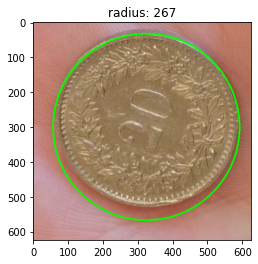

returning chf_0.2


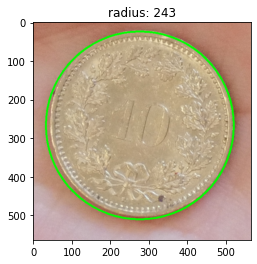

returning chf_0.2
L0000000,0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0
./data/test//L0000001.JPG
detected 10 circles


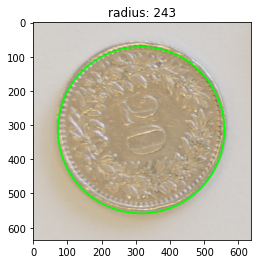

returning chf_0.2


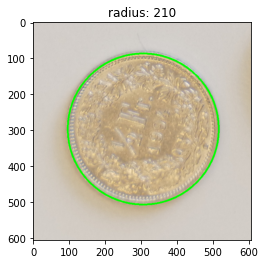

returning chf_0.5


KeyboardInterrupt: 

In [36]:
index = np.random.randint(0, 17)
csv_file = csv_header
csv_file += "\n"
with torch.no_grad():
# index = 16
    linear.eval()

    # labeled_coins_dir = "./data/labeled_coins/"
    # selected_dir = f"{labeled_coins_dir}{class_names[index]}"
    # files = os.listdir(selected_dir)
    # selected_file = random.choice(files)
    # selected_file_path = f"{selected_dir}/{selected_file}"
    # print(selected_file_path)
    test_index = 17

    for i, path in enumerate(get_test_data_paths()):
        print(path)
    
        # path = "./data/test/L0000113.JPG"
        coins = find_circles(path)
        # coins = find_circles("./data/train/1. neutral_bg/L1010277.JPG")
        
        p = np.zeros(16, dtype=np.uint8)
        for coin in coins:
            shape = coin.shape
            if shape[0] <10 or shape[1]<10: continue
            # print(coin.shape)
        
            
            
            # coin = np.array(im.open(selected_file_path))
            # coin.show()


            x = extract_features(coin).to(device)
            # print(x)
            x = torch.unsqueeze(x, 0)

            pred_test = linear(x).flatten()
            pred_class = torch.argmax(pred_test)
            
           
            
            
            proba = (torch.softmax(pred_test, dim=0)*100)
            max_proba = torch.max(proba)
            # print(max_proba)
            # plt.title(class_names[pred_class.item()])
            # plt.imshow(coin)
            # plt.show()
            if pred_class == 16: continue
            
            # if max_proba < 0.7:
            
            if pred_class==3 or pred_class == 4 or pred_class == 5:
                # print("checking chf cents")
                pred_class = test_chf_cents(coin, pred_class.item())
                
            #     elif pred_class == 12 or pred_class == 13 or pred_class == 14:
            #         # print("checking eur cents")
                    
            #         pred_class = test_eur_cents(coin, pred_class.item())
                
            #     elif pred_class == 1 or pred_class == 2:
            #         # print("checking chf francs")
                    
            #         pred_class = test_chf_francs(coin, pred_class.item())
            
            # if pred_class == 4 or pred_class==5:
            #     radius = find_radius(coin)
            #     print(f"radius: {radius}")
            #     if radius != 0:
            #         if radius < 235:
            #             pred_class = 4
            #         elif radius < 220:
            #             pred_class = 6
            #         else: pred_calss = 5
                
            # print(pred_class)
            
            p[pred_class] += 1
        # print(f"pred {pred_class}")
        # print(f"target: {index}")
        
        # print(p)
        p_string = np.array2string(p, separator=', ', precision=0).replace("[", "").replace("]", "")
        csv_row = f"{path_to_filename(path)},{p_string}"
        print(csv_row)
        # print(csv_row)
        csv_file += csv_row
        csv_file += "\n"

with open('./data/submission.csv', 'w') as file:
    # Write a string to the file
    file.write(csv_file)
    
# print(csv_row)


## extracting all coins

In [ ]:
from PIL import Image as im 
paths = get_training_data_paths()
print(len(paths))

# for path in paths:
for path in paths:
    circles =find_circles(path)
    for i, circle in enumerate(circles):
        file_number = path.split("/")[-1].split(".")[0]
        print(file_number)
        im.fromarray(circle).save(f"./data/unlabeled_coins/{file_number}_{i}.jpg")
    


### label hd coins

In [ ]:
target_dir = "./data/hd_coins/"
source_dir = "./data/labeled_coins/"
unlabeled_dir = "./data/unlabeled_coins/"
for d in os.listdir(source_dir):
    class_dir = target_dir + d
    if not os.path.exists(class_dir):
        os.mkdir(class_dir)
    
    for file in os.listdir(source_dir+d):
        src_file = unlabeled_dir+file
        dst_file = target_dir + d+"/"+file
        os.rename(src_file, dst_file)
        # print(dst_file)

## compute area

In [ ]:
# coins_dir = "./data/labeled_coins/"

# radius_list = []

# for d in os.listdir(coins_dir):
#     if d == "bg": continue
    
#     class_dir = coins_dir +d +"/"
#     print(class_dir)

path = get_test_data_paths()[5]

# for path in os.listdir(class_dir):
    
#     img = cv.imread(class_dir+path, cv.IMREAD_GRAYSCALE)
#     # plt.imshow(img, cmap="gray")
#     # plt.show()
#     # print(path)
    
coins = find_circles(path)


for coin in coins:
        print(find_radius(coin))
   
        # pass
# print(f"radius for {d} - {np.mean(radius_list)}")
 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, measure
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage as ndi

def detect_coins(image):
    # Load the image
    # image = io.imread(image_path)
    # if image is None:
    #     raise FileNotFoundError(f"Image not found: {image_path}")

    # # Convert to grayscale
    gray = (color.rgb2gray(image)*255).astype(np.uint8)

    # Apply Gaussian filter to smooth the image
    blurred = filters.gaussian(gray, sigma=2.0)

    # Apply Otsu's thresholding
    thresh = filters.threshold_otsu(blurred)
    binary = blurred < thresh

    # Remove small objects
    cleaned = morphology.remove_small_objects(binary, 50)

    # Compute the distance transform
    distance = ndi.distance_transform_edt(cleaned)

    # Find local maxima
    local_maxi = peak_local_max(distance, footprint=np.ones((3, 3)), labels=cleaned)

    # Perform connected component labeling
    markers = measure.label(local_maxi)

    # Apply watershed algorithm
    labels = watershed(-distance, markers, mask=cleaned)

    # Plot the result
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image, cmap=plt.cm.gray)
    for region in measure.regionprops(labels):
        # Draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                             fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

    ax.set_title('Detected Coins')
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Example usage:
# detect_coins('coins.jpg')


In [ ]:
def create_ball_array(radius):
    """
    Create a 2D numpy array representing a circle.
    
    Parameters:
        radius (int): Radius of the circle.
        
    Returns:
        numpy.ndarray: 2D numpy array representing the circle.
    """
    # Create an empty 2D numpy array with dimensions (2*radius, 2*radius)
    circle = np.zeros((2 * radius, 2 * radius), dtype=np.uint8)
    
    # Generate coordinates of the circle's center
    center_x, center_y = radius, radius
    
    # Fill the array with values representing the circle
    for x in range(2 * radius):
        for y in range(2 * radius):
            if (x - center_x) ** 2 + (y - center_y) ** 2 <= radius ** 2:
                circle[x, y] = 1
    
    return circle

In [ ]:

# img = loadImageOfType(ImageType.NOISY, downsample=8, grayscale=True)
from skimage.morphology import closing
d = "./data/train/2. noisy_bg////"

R_chf = 178
G_chf = 161
B_chf = 141


for path in os.listdir(d)[0:10]:

    # path = os.listdir(d)[2]
    file_path = d + path
    coins = find_circles(file_path)
    for coin in coins:
        print(find_radius(coin))
               

        # print(img)
        # t = 20
        
        # mask = (coin[:, :, 0] < R_chf +t) & (coin[:, :, 0] > R_chf - t) & (coin[:, :, 1] < G_chf +t) & (coin[:, :, 1] > G_chf - t)& (coin[:, :, 2] < B_chf +t/2) & (coin[:, :, 2] > B_chf - t)
        # thresh = np.zeros((coin.shape[0], coin.shape[1]))
        
        # thresh[mask] = 1
        

        

        # plotHistogram(img)

        # elevation_map = filters.sobel(img)
        # markers = np.zeros_like(img)
        # # markers[img < 150] = 2
        # # markers[img > 180] = 1
        # markers[img < 150] = 1
        # markers[img > 220] = 2
        # segmentation_coins = (segmentation.watershed(elevation_map, markers) - 1).astype(bool)
        # segmentation_coins = closing(segmentation_coins, create_ball_array(img.shape[0]//4))
        # pixel_nb = np.sum(segmentation_coins.astype(np.uint8))
        # radius = np.sqrt(pixel_nb/(np.pi))
        # print(radius)
        
        # plt.imshow(coin)
        # plt.show()


        # fig, axs = plt.subplots(1, 2)
        # fig.set_size_inches(15, 10)
        # axs[0].imshow(coin, cmap="gray")
        # # axs[1].imshow(segmentation_coins, cmap="gray")
        # plt.show()

In [32]:
file1 = open('./data/submission.csv', 'r')
lines = file1.readlines()
file2 = open('./data/submission_padding.csv', 'r')
lines2 = file2.readlines()

diff = 0
for i in range(len(lines2)):
    if lines[i] != lines2[i]:
        diff+=1
        print(lines[i], lines2[i])
print(diff)


L0000000,0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0
 L0000000,0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

L0000002,1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1
 L0000002,1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

L0000008,0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1
 L0000008,0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1

L0000012,0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0
 L0000012,0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0

L0000014,0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0
 L0000014,0, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

L0000016,0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0
 L0000016,0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

L0000017,1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0
 L0000017,1, 0, 2, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0

L0000023,1, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1
 L0000023,1, 1, 2, 2, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1

L0000027,1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0
 L0000027,1, 1, 0, 0, 1, 0, 0, 1